# Цель

<div class="alert alert-block alert-warning">
Разработать модель, предсказывающую таргет.  
    
Описание полей:  
PARTNER – наименование партнера (банка, мфо)  
APPID – идентификатор заявки  
APPDATE – дата заявки  
DOCSERNUM – номер паспорта   
MOBILEPHONE – номер мобильного   
EMAIL – электронный адрес  
LIM – сумма кредита  
PRODUCTTYPE – тип кредита  
CHANNEL – канал поступления заявки  
MODEL – наименование товара  
TARGET – факт выхода в просрочку  
<div>

In [1]:
# Импорты библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve, confusion_matrix)
import seaborn as sns
from sklearn import metrics

In [104]:
pd.set_option('display.float_format',  '{:.3f}'.format)
pd.set_option('max_columns', None)
pd.set_option('max_rows', 100)
pd.set_option('max_colwidth', None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [68]:
# Функции для графиков

def plt_dist(value_to_plot):
    plt.hist(data[value_to_plot])
    plt.title(value_to_plot)
    plt.ylabel('Frequency')
    plt.show()

In [69]:
sns.set(rc={'figure.figsize':(9.36,6.62)})
sns.set(style='darkgrid')

def sns_dist(value_to_plot):
    sns.countplot(y = value_to_plot,
                  data = data_df,
                  palette = 'hls',
                  order = data_df[value_to_plot].value_counts().index
                 ).set(title=value_to_plot)
    plt.show()
    
    

# Загружаем данные

In [70]:
data_df = pd.read_csv('sample_BKI.csv', sep = ';')

In [71]:
# размерность исходной выборки
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567391 entries, 0 to 567390
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   PARTNER      567391 non-null  object
 1   APPID        567391 non-null  object
 2   APPDATE      567391 non-null  object
 3   DOCSERNUM    567391 non-null  object
 4   MOBILEPHONE  567391 non-null  object
 5   EMAIL        567391 non-null  object
 6   LIM          567391 non-null  object
 7   PRODUCTTYPE  567391 non-null  object
 8   CHANNEL      567391 non-null  object
 9   MODEL        422661 non-null  object
 10  TARGET       567391 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 47.6+ MB


In [72]:
# размерность исходной выборки
data_df.shape

(567391, 11)

In [73]:
data_df.dtypes

PARTNER        object
APPID          object
APPDATE        object
DOCSERNUM      object
MOBILEPHONE    object
EMAIL          object
LIM            object
PRODUCTTYPE    object
CHANNEL        object
MODEL          object
TARGET          int64
dtype: object

In [74]:
data_df.head(3)

,PARTNER,APPID,APPDATE,DOCSERNUM,MOBILEPHONE,EMAIL,LIM,PRODUCTTYPE,CHANNEL,MODEL,TARGET
0,PARTNER28,APPLICATID1015331,07.06.2021 11:30:14,DOCSERNUM1,MOBILEPHONE43681,EMAIL158187,0,Другой тип кредита,Значение не передается,0,0
1,PARTNER6,APPLICATID503939,29.07.2021 17:46:03,DOCSERNUM2,MOBILEPHONE407081,EMAIL143461,0,Другой тип кредита,Точка продаж,EMPTY,0
2,PARTNER6,APPLICATID503936,29.07.2021 17:45:43,DOCSERNUM2,MOBILEPHONE407081,EMAIL143461,"32374,1","POS кредит (потребительский кредит, кредит на товар)",Точка продаж,"15.6"" Ноутбук HP Laptop 15-gw0040ur (FHD/IPS) Athlon 3150u/4096/SSD 256/AMD R620 2Gb/Win10/Gray HP",0


## Меняем типы данных

In [75]:
# data_df['DateTime'] = pd.to_datetime(data_df['APPDATE'], format='%d.%m.%Y %H:%M:%S')
data_df[data_df['APPID']  == 'APPLICATID235026']

,PARTNER,APPID,APPDATE,DOCSERNUM,MOBILEPHONE,EMAIL,LIM,PRODUCTTYPE,CHANNEL,MODEL,TARGET
233,PARTNER43,APPLICATID235026,24.12.2021,DOCSERNUM100,MOBILEPHONE375880,EMAIL143461,1705000,Кредит на автомобиль,Брокер (оффлайн),Toyota RAV4,0


<div class="alert alert-block alert-danger">
В исходном файле в поле APPDATE содержатся разные типы данных: DATE и DATETIME  
    
Например, APPLICATID235026 - DATE  
APPLICATID636881 - DATETIME  
</div>

In [76]:
%%time
data_df['APPDT'] = data_df['APPDATE'].str.split(' ').str[0]

Wall time: 581 ms


In [77]:
data_df['APPDT'] = pd.to_datetime(data_df['APPDT'], format='%d.%m.%Y')
data_df['APPMONTH'] = data_df['APPDT'].to_numpy().astype('datetime64[M]')

In [78]:
data_df[['APPDATE', 'APPDT', 'APPMONTH']].head(3)

,APPDATE,APPDT,APPMONTH
0,07.06.2021 11:30:14,2021-06-07,2021-06-01
1,29.07.2021 17:46:03,2021-07-29,2021-07-01
2,29.07.2021 17:45:43,2021-07-29,2021-07-01


In [79]:
# преобразуем лимит в число
data_df['LIMIT'] = data_df['LIM'].str.replace(',', '.')
data_df['LIMIT'] = data_df['LIMIT'].astype('float')

In [105]:
data_df[['LIM', 'LIMIT']].head(7)

,LIM,LIMIT
0,0,0.000
1,0,0.000
2,"32374,1",32374.100
3,"30524,1",30524.100
4,0,0.000
5,588529,588529.000
6,80000,80000.000


In [191]:
# Удаляем лишние колонки

data_df = data_df.drop(columns=['APPDATE', 'LIM'])

In [192]:
data_df.dtypes

PARTNER                object
APPID                  object
DOCSERNUM              object
MOBILEPHONE            object
EMAIL                  object
PRODUCTTYPE            object
CHANNEL                object
MODEL                  object
TARGET                  int64
APPDT          datetime64[ns]
APPMONTH       datetime64[ns]
LIMIT                 float64
dtype: object

# Описательные статистики

In [193]:
data_df.describe(percentiles = [0.01, 0.25, 0.5, 0.75, 0.99, 0.995, 0.999]).T

,count,mean,std,min,1%,25%,50%,75%,99%,99.5%,99.9%,max
TARGET,567391.000,0.022,0.145,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000
LIMIT,567391.000,176886.041,590220.395,0.000,0.000,12281.500,40248.000,99000.000,2311203.100,3000000.000,5507270.000,100000000.000


In [194]:
data_df.describe(include=[object])  

,PARTNER,APPID,DOCSERNUM,MOBILEPHONE,EMAIL,PRODUCTTYPE,CHANNEL,MODEL
count,567391,567391,567391,567391,567391,567391,567391,422661
unique,46,567391,216566,229061,82358,11,10,74146
top,PARTNER6,APPLICATID1015331,DOCSERNUM12603,MOBILEPHONE400101,EMAIL143461,"POS кредит (потребительский кредит, кредит на товар)",Значение не передается,EMPTY
freq,127215,1,279,2668,226782,266633,184532,139779


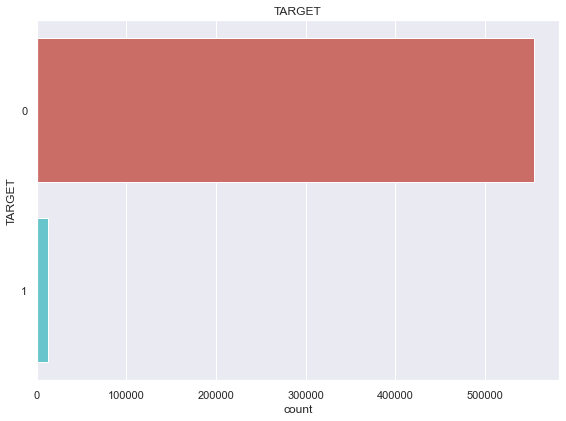

In [63]:
sns_dist('TARGET')

<div class="alert alert-block alert-info">
Можем заметить, что все наши данные (кроме таргета и суммы кредита) это качественные переменные.  
    
Наши заявки уникальны, т.к. APPID не имеет дублей.  
    
Мы работаем с 46 партнерами и с 11 различными кредитными продуктами.  
    
Всего у нас 10 каналов поступления заявки.
<div>

## Кредиты с очень большой суммой (больше чем 99.9 персентиль)

In [94]:
Mortgage_df = data_df[data_df['PRODUCTTYPE'] == 'Ипотека']

In [97]:
Mortgage_df.describe(percentiles = [0.01, 0.25, 0.5, 0.75, 0.99, 0.995, 0.999]).T

,count,mean,std,min,1%,25%,50%,75%,99%,99.5%,99.9%,max
TARGET,789.000,0.001,0.036,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.212,1.000
LIMIT,789.000,4561988.260,6173854.827,50000.000,600000.000,2000000.000,3000000.000,5000000.000,50000000.000,50000000.000,50000000.000,50000000.000


<div class="alert alert-block alert-info">
Для ипотеки лимит в 50 млн рублей - нормально
<div>

In [119]:
data_df[['APPID', 'PARTNER', 'LIMIT', 'PRODUCTTYPE', 'CHANNEL', 'MODEL', 'TARGET', 'APPMONTH']][data_df['PRODUCTTYPE'] == 'Ипотека'].sort_values('LIMIT', ascending = False).head(20)

,APPID,PARTNER,LIMIT,PRODUCTTYPE,CHANNEL,MODEL,TARGET,APPMONTH
478503,APPLICATID851668,PARTNER9,50000000.000,Ипотека,Интернет,NaN,0,2021-09-01
162801,APPLICATID851193,PARTNER9,50000000.000,Ипотека,Интернет,NaN,0,2021-11-01
496913,APPLICATID851199,PARTNER9,50000000.000,Ипотека,Интернет,NaN,0,2021-11-01
530618,APPLICATID851673,PARTNER9,50000000.000,Ипотека,Интернет,NaN,0,2021-10-01
295975,APPLICATID1131302,PARTNER9,50000000.000,Ипотека,Интернет,NaN,0,2021-11-01
273773,APPLICATID851207,PARTNER9,50000000.000,Ипотека,Интернет,NaN,0,2021-11-01
343546,APPLICATID851677,PARTNER9,50000000.000,Ипотека,Интернет,NaN,0,2021-11-01
937,APPLICATID851667,PARTNER9,50000000.000,Ипотека,Интернет,NaN,0,2021-09-01
162802,APPLICATID851202,PARTNER9,50000000.000,Ипотека,Интернет,NaN,0,2021-11-01
162803,APPLICATID851201,PARTNER9,50000000.000,Ипотека,Интернет,NaN,0,2021-11-01


In [118]:
data_df[['APPID', 'PARTNER', 'LIMIT', 'PRODUCTTYPE', 'CHANNEL', 'MODEL', 'TARGET', 'APPMONTH']][data_df['PRODUCTTYPE'] != 'Ипотека'].sort_values('LIMIT', ascending = False).head(20)

,APPID,PARTNER,LIMIT,PRODUCTTYPE,CHANNEL,MODEL,TARGET,APPMONTH
237591,APPLICATID955664,PARTNER9,100000000.000,Неизвестный тип кредита,Отделение,NaN,0,2022-01-01
217793,APPLICATID90675,PARTNER40,80000000.000,Неизвестный тип кредита,Отделение,EMPTY,0,2021-12-01
175152,APPLICATID45657,PARTNER40,60000000.000,Неизвестный тип кредита,Отделение,EMPTY,0,2021-08-01
199586,APPLICATID767591,PARTNER3,50000000.000,Другой тип кредита,Интернет,NaN,0,2021-08-01
217794,APPLICATID54536,PARTNER40,30000000.000,Неизвестный тип кредита,Отделение,EMPTY,0,2021-09-01
455387,APPLICATID217601,PARTNER38,21196600.000,Кредит на автомобиль,Значение не передается,Bentley Bentley Continental,0,2022-02-01
455385,APPLICATID217596,PARTNER38,21196600.000,Кредит на автомобиль,Значение не передается,Bentley Bentley Continental,0,2022-02-01
455388,APPLICATID217682,PARTNER38,21196600.000,Кредит на автомобиль,Значение не передается,Bentley Bentley Continental,0,2022-02-01
455384,APPLICATID217791,PARTNER38,19999950.000,Кредит на автомобиль,Значение не передается,Bentley Bentley Continental,0,2022-02-01
455386,APPLICATID220109,PARTNER38,19999950.000,Кредит на автомобиль,Значение не передается,Bentley Bentley Continental,0,2022-02-01


<div class="alert alert-block alert-info">
Решил не убирать наблюдения с очень большой суммой. Скорее всего это какие-то VIP клиенты
<div>

## Группировка по типу кредита 

In [123]:
(
    data_df.groupby('PRODUCTTYPE').describe(percentiles = [0.01, 0.5, 0.99, 0.999]).sort_values([('TARGET', 'mean')], ascending = False)
    [[('TARGET', 'count'), ('TARGET', 'mean'), ('LIMIT', 'mean'), ( 'LIMIT',   '1%'), ( 'LIMIT',   '50%'), ( 'LIMIT',   '99%'), ( 'LIMIT',   '99.9%'), ( 'LIMIT',   'max')]]
)

TARGET        \
                                                               count  mean   
PRODUCTTYPE                                                                  
Микрозайм                                                  22133.000 0.240   
Дебетовая карта с овердрафтом                                195.000 0.026   
Кредит наличными (нецелевой)                               34028.000 0.025   
Предварительная оценка заёмщика без указания типа кредита   1474.000 0.018   
Кредитная карта                                            50662.000 0.017   
Другой тип кредита                                         77933.000 0.016   
POS кредит (потребительский кредит, кредит на товар)      266633.000 0.013   
Кредит на строительство недвижимости                         191.000 0.010   
Неизвестный тип кредита                                    86736.000 0.005   
Кредит на автомобиль                                       26617.000 0.005   
Ипотека                                                      789.000 0.001   

                                                                LIMIT  \
                                                                 mean   
PRODUCTTYPE                                                             
Микрозайм                                                   11733.087   
Дебетовая карта с овердрафтом                              183659.359   
Кредит наличными (нецелевой)                               289168.845   
Предварительная оценка заёмщика без указания типа кредита  118580.054   
Кредитная карта                                             73732.136   
Другой тип кредита                                           8066.840   
POS кредит (потребительский кредит, кредит на товар)        99141.440   
Кредит на строительство недвижимости                       299886.344   
Неизвестный тип кредита                                    232204.088   
Кредит на автомобиль                                      1332149.021   
Ипотека                                                   4561988.260   

                                                                      \
                                                                  1%   
PRODUCTTYPE                                                            
Микрозайм                                                      0.000   
Дебетовая карта с овердрафтом                                  0.000   
Кредит наличными (нецелевой)                               10000.000   
Предварительная оценка заёмщика без указания типа кредита      0.000   
Кредитная карта                                                0.000   
Другой тип кредита                                             0.000   
POS кредит (потребительский кредит, кредит на товар)           0.000   
Кредит на строительство недвижимости                       20000.000   
Неизвестный тип кредита                                     1000.000   
Кредит на автомобиль                                      230100.452   
Ипотека                                                   600000.000   

                                                                       \
                                                                  50%   
PRODUCTTYPE                                                             
Микрозайм                                                   10000.000   
Дебетовая карта с овердрафтом                              109000.000   
Кредит наличными (нецелевой)                               100000.000   
Предварительная оценка заёмщика без указания типа кредита       0.000   
Кредитная карта                                             51000.000   
Другой тип кредита                                              0.000   
POS кредит (потребительский кредит, кредит на товар)        45000.000   
Кредит на строительство недвижимости                       204067.200   
Неизвестный тип кредита                                     60000.000   
Кредит на автомобиль                                      110

In [65]:
data_df.groupby('PRODUCTTYPE').count().sort_values('PARTNER', ascending = False)['PARTNER']/data_df['TARGET'].count()

PRODUCTTYPE
POS кредит (потребительский кредит, кредит на товар)        0.470
Неизвестный тип кредита                                     0.153
Другой тип кредита                                          0.137
Кредитная карта                                             0.089
Кредит наличными (нецелевой)                                0.060
Кредит на автомобиль                                        0.047
Микрозайм                                                   0.039
Предварительная оценка заёмщика без указания типа кредита   0.003
Ипотека                                                     0.001
Дебетовая карта с овердрафтом                               0.000
Кредит на строительство недвижимости                        0.000
Name: PARTNER, dtype: float64

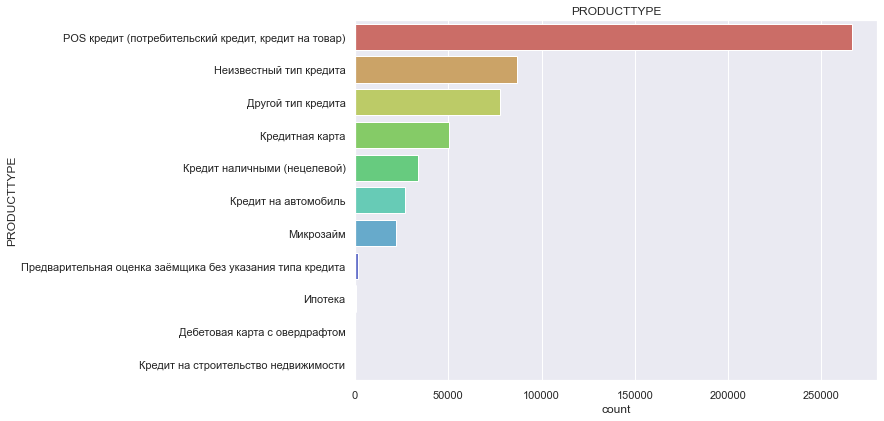

In [66]:
sns_dist('PRODUCTTYPE')

<div class="alert alert-block alert-info">
Видно, что самый большой DR (Deafault Rate) в продукте "Микрозайм" - 24%, а самый низкий DR в залоговых продуктах "Ипотека" и "Кредит на автомобиль" - 0.1% и 0.5% соответственно. 

При этом структура заявок следующая: почти половина (47%) приходится на POS и больше четверти на другие и неизвестые кредиты (29%). На остальные 8 продуктов приходится только 24% заявок.
</div> 

## Группировка по каналу поступления заявки

In [20]:
# data_df.groupby('CHANNEL').describe().sort_values([('TARGET', 'count')], ascending = False)[[('TARGET', 'count'), ('TARGET', 'mean')]]

In [152]:
x1 = data_df.groupby('CHANNEL').describe(percentiles = [0.01, 0.5, 0.99, 0.999]).sort_values([('TARGET', 'mean')], ascending = False)[[('TARGET', 'count'), ('TARGET', 'mean'), ('LIMIT', 'mean'), ( 'LIMIT',   '1%'), ( 'LIMIT',   '50%'), ( 'LIMIT',   '99%'), ( 'LIMIT',   '99.9%'), ( 'LIMIT',   'max')]]

x2 = data_df.groupby('CHANNEL').count().sort_values('PARTNER', ascending = False)['PARTNER']/data_df['TARGET'].count()
x2 = pd.DataFrame(x2)
channel_df = pd.merge(x1, x2, left_index=True, right_index=True)
#channel_df.columns = ['count', 'mean', 'share']
#channel_df.sort_values('count', ascending = False)
channel_df

C:\Users\75BD~1\AppData\Local\Temp/ipykernel_6048/1922479184.py:5: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  channel_df = pd.merge(x1, x2, left_index=True, right_index=True)


,"(TARGET, count)","(TARGET, mean)","(LIMIT, mean)","(LIMIT, 1%)","(LIMIT, 50%)","(LIMIT, 99%)","(LIMIT, 99.9%)","(LIMIT, max)",PARTNER
CHANNEL,,,,,,,,,
Интернет,51340.000,0.083,211418.570,0.000,28685.500,2967206.000,9547000.000,50000000.000,0.090
Предварительная оценка заёмщика,345.000,0.038,506628.986,36000.000,500000.000,1000000.000,1000000.000,1000000.000,0.001
Кросс-селл,10438.000,0.029,133675.714,10000.000,50000.000,998678.000,1619134.012,2754440.000,0.018
Колл-центр,1642.000,0.026,105269.998,0.000,65000.000,982766.470,3611304.000,5000000.000,0.003
Точка продаж,142015.000,0.020,109244.867,0.000,24500.000,1906636.000,3741204.498,9658836.000,0.250
Значение не передается,184532.000,0.018,225822.454,0.000,45000.000,2500000.000,5456960.000,21196600.000,0.325
Другое,413.000,0.012,604215.293,12000.000,300000.000,4037000.000,6090931.688,6855326.000,0.001
Брокер (оффлайн),74474.000,0.009,72324.557,0.000,35331.000,1274913.151,3884208.900,9710000.000,0.131
Отделение,101948.000,0.007,242180.335,1000.000,75000.000,3000000.000,6511173.000,100000000.000,0.180


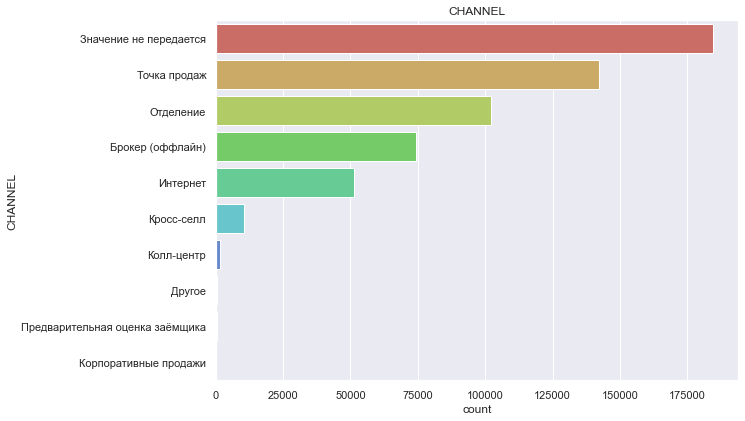

In [135]:
sns_dist('CHANNEL')

<div class="alert alert-block alert-info">
Cамый большой DR в канале интернет - 8.3%, а самый низкий DR в отделениях и корпоративных продажах - 0.7% и 0.4% соответственно. 

Структура каналов заявок следующая: по 33% заяков мы не знаем канал продаж, по 25% - это точка продаж и в 18% заявка пришла через отделение.
</div> 

## Группировка по партнерам

In [153]:
x1 = data_df.groupby('PARTNER').describe(percentiles = [0.01, 0.5, 0.99, 0.999]).sort_values([('TARGET', 'mean')], ascending = False)[[('TARGET', 'count'), ('TARGET', 'mean'), ('LIMIT', 'mean'), ( 'LIMIT',   '1%'), ( 'LIMIT',   '50%'), ( 'LIMIT',   '99%'), ( 'LIMIT',   '99.9%'), ( 'LIMIT',   'max')]]
x2 = data_df.groupby('PARTNER').count().sort_values('PARTNER', ascending = False)['APPID']/data_df['TARGET'].count()
x2 = pd.DataFrame(x2)
partner_df = pd.merge(x1, x2, left_index=True, right_index=True)
#partner_df.columns = ['count', 'mean', 'share']

C:\Users\75BD~1\AppData\Local\Temp/ipykernel_6048/4015566789.py:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  partner_df = pd.merge(x1, x2, left_index=True, right_index=True)


In [154]:
partner_df[partner_df[('TARGET', 'count')] > 1000].head(10)

,"(TARGET, count)","(TARGET, mean)","(LIMIT, mean)","(LIMIT, 1%)","(LIMIT, 50%)","(LIMIT, 99%)","(LIMIT, 99.9%)","(LIMIT, max)",APPID
PARTNER,,,,,,,,,
PARTNER2,2225.000,0.401,18570.562,2000.000,19000.000,30000.000,30000.000,30000.000,0.004
PARTNER32,1722.000,0.355,20645.761,1000.000,15000.000,100000.000,100000.000,100000.000,0.003
PARTNER25,1498.000,0.350,0.000,0.000,0.000,0.000,0.000,0.000,0.003
PARTNER35,2507.000,0.268,10592.225,3000.000,10000.000,19000.000,28962.700,32160.000,0.004
PARTNER18,3095.000,0.184,0.000,0.000,0.000,0.000,0.000,0.000,0.005
PARTNER27,1971.000,0.163,28282.529,3000.000,18178.000,100000.000,500000.000,2300000.000,0.003
PARTNER45,7491.000,0.140,12098.251,3000.000,11000.000,30000.000,50000.000,100000.000,0.013
PARTNER31,35605.000,0.034,120110.851,5185.000,50000.000,1000000.000,5000000.000,6498150.000,0.063
PARTNER6,127215.000,0.018,40837.691,0.000,21516.000,351840.000,998566.000,2754440.000,0.224


In [155]:
partner_df.sort_values(('TARGET', 'count'), ascending = False).head(10)

,"(TARGET, count)","(TARGET, mean)","(LIMIT, mean)","(LIMIT, 1%)","(LIMIT, 50%)","(LIMIT, 99%)","(LIMIT, 99.9%)","(LIMIT, max)",APPID
PARTNER,,,,,,,,,
PARTNER6,127215.000,0.018,40837.691,0.000,21516.000,351840.000,998566.000,2754440.000,0.224
PARTNER28,104237.000,0.010,124181.848,0.000,45000.000,1811528.689,3330337.744,7523384.190,0.184
PARTNER40,80650.000,0.005,226943.895,1500.000,60000.000,3000000.000,6769956.456,80000000.000,0.142
PARTNER23,75993.000,0.008,65657.707,5149.840,36000.000,644971.480,2322353.600,4502235.000,0.134
PARTNER31,35605.000,0.034,120110.851,5185.000,50000.000,1000000.000,5000000.000,6498150.000,0.063
PARTNER9,31074.000,0.010,284980.147,0.000,79308.000,3640000.000,12000000.000,100000000.000,0.055
PARTNER20,23410.000,0.012,108721.060,0.000,23159.000,1700000.000,3500000.000,18900000.000,0.041
PARTNER38,14991.000,0.003,1336668.040,255427.005,1055140.000,5502460.300,11016000.000,21196600.000,0.026
PARTNER8,12007.000,0.012,78698.757,0.000,47176.000,900000.000,1349877.000,15000000.000,0.021


<div class="alert alert-block alert-info">
Есть партнеры с очень большим DR (среди тех от кого приходят более 1000 заявок).   
    
Например, PARTNER2 с DR 40% и PARTNER32, PARTNER25 c DR 35%
    
При этом "Микрозаймы" при 4% портфеля дают 40% вклада в общий DR. Давайте посмотрим на этих трех партнеров подробнее
</div> 

In [27]:
data_df[data_df['PRODUCTTYPE'] != 'Микрозайм'].describe().T

,count,mean,std,min,25%,50%,75%,max
TARGET,545258.000,0.013,0.112,0.000,0.000,0.000,0.000,1.000


### PARTNER2

In [156]:
partner2_df = data_df[data_df['PARTNER'] == 'PARTNER2']

In [157]:
partner2_df.groupby('PRODUCTTYPE').describe().sort_values([('TARGET', 'mean')], ascending = False)[[('TARGET', 'count'), ('TARGET', 'mean')]].T

PRODUCTTYPE   Микрозайм
TARGET count   2225.000
       mean       0.401

In [158]:
partner2_df.groupby('CHANNEL').describe().sort_values([('TARGET', 'mean')], ascending = False)[[('TARGET', 'count'), ('TARGET', 'mean')]].T

CHANNEL       Интернет
TARGET count  2225.000
       mean      0.401

### PARTNER32

In [159]:
partner32_df = data_df[data_df['PARTNER'] == 'PARTNER32']

In [160]:
partner32_df.groupby('PRODUCTTYPE').describe().sort_values([('TARGET', 'mean')], ascending = False)[[('TARGET', 'count'), ('TARGET', 'mean')]].T

PRODUCTTYPE   Микрозайм
TARGET count   1722.000
       mean       0.355

In [161]:
partner32_df.groupby('CHANNEL').describe().sort_values([('TARGET', 'mean')], ascending = False)[[('TARGET', 'count'), ('TARGET', 'mean')]].T

CHANNEL       Точка продаж
TARGET count      1722.000
       mean          0.355

### PARTNER25

In [162]:
partner25_df = data_df[data_df['PARTNER'] == 'PARTNER25']

In [163]:
partner25_df.groupby('PRODUCTTYPE').describe().sort_values([('TARGET', 'mean')], ascending = False)[[('TARGET', 'count'), ('TARGET', 'mean')]].T

PRODUCTTYPE   Микрозайм
TARGET count   1498.000
       mean       0.350

In [164]:
partner25_df.groupby('CHANNEL').describe().sort_values([('TARGET', 'mean')], ascending = False)[[('TARGET', 'count'), ('TARGET', 'mean')]].T

CHANNEL       Брокер (оффлайн)  Интернет  Колл-центр
TARGET count             1.000  1474.000      23.000
       mean              1.000     0.349       0.348

<div class="alert alert-block alert-info">
С партнерами PARTNER и PARTNER25 высокая дефолтность выглядит логичной, т.к. они работают в самом рискованном канале (интернет) и с самым рисковынным продуктом (микрозаймы)

А вот с PARTNER32 высокий DR выглядит странно, т.к. они работают с точками продаж
</div> 

### Микрозаймы

In [165]:
microloan_df = data_df[data_df['PRODUCTTYPE'] == 'Микрозайм']

In [166]:
microloan_df.groupby('CHANNEL').describe().sort_values([('TARGET', 'mean')], ascending = False)[[('TARGET', 'count'), ('TARGET', 'mean')]].T

CHANNEL       Отделение  Точка продаж  Интернет  Брокер (оффлайн)  \
TARGET count    179.000      1875.000 16086.000           303.000   
       mean       0.358         0.335     0.237             0.234   

CHANNEL       Значение не передается  Колл-центр  
TARGET count                3477.000     213.000  
       mean                    0.202       0.155

In [167]:
microloan_df.groupby('PARTNER').describe().sort_values([('TARGET', 'mean')], ascending = False)[[('TARGET', 'count'), ('TARGET', 'mean')]].T

PARTNER       PARTNER42  PARTNER21  PARTNER29  PARTNER2  PARTNER26  PARTNER33  \
TARGET count     11.000    185.000    221.000  2225.000    729.000     89.000   
       mean       0.818      0.481      0.448     0.401      0.391      0.382   

PARTNER       PARTNER32  PARTNER25  PARTNER41  PARTNER35  PARTNER27  \
TARGET count   1722.000   1498.000    293.000   2507.000    942.000   
       mean       0.355      0.350      0.345      0.268      0.236   

PARTNER       PARTNER18  PARTNER17  PARTNER45  PARTNER15  
TARGET count   3095.000    972.000   7491.000    153.000  
       mean       0.184      0.145      0.140      0.118

## Группировка по MODEL

In [190]:
data_df[['APPID', 'MODEL']].groupby('MODEL').count().sort_values('APPID', ascending = False).head(7)

,APPID
MODEL,
EMPTY,139779
0,104237
Кредитная карта свобода,1286
KIA Kia Rio,1235
смартфон,1135
ВАЗ ВАЗ Vesta,993
"""ТОВАРЫ ASKONA"" ""ТОВАРЫ ASKONA"" МОДЕЛЬ",894


# Этап валидации входящих данных

In [168]:
# Количетсво пропусков в данных
data_df.isna().sum()

PARTNER             0
APPID               0
APPDATE             0
DOCSERNUM           0
MOBILEPHONE         0
EMAIL               0
LIM                 0
PRODUCTTYPE         0
CHANNEL             0
MODEL          144730
TARGET              0
APPDT               0
APPMONTH            0
LIMIT               0
dtype: int64

In [169]:
share_missing = round(data_df.isna().sum()/data_df.count(), 3)
print('Доля пропущенных переменных')
share_missing

Доля пропущенных переменных


PARTNER       0.000
APPID         0.000
APPDATE       0.000
DOCSERNUM     0.000
MOBILEPHONE   0.000
EMAIL         0.000
LIM           0.000
PRODUCTTYPE   0.000
CHANNEL       0.000
MODEL         0.342
TARGET        0.000
APPDT         0.000
APPMONTH      0.000
LIMIT         0.000
dtype: float64

# Распределение данных во времени

In [195]:
time_df = data_df[['APPMONTH', 'TARGET']].groupby('APPMONTH').agg(['count', 'mean'])
time_df.columns  = ['count', 'mean']

In [196]:
time_df

,count,mean
APPMONTH,,
2021-06-01,41227,0.009
2021-07-01,45624,0.015
2021-08-01,48504,0.013
2021-09-01,45785,0.016
2021-10-01,46958,0.016
2021-11-01,51769,0.021
2021-12-01,61548,0.021
2022-01-01,46959,0.028
2022-02-01,45334,0.031


<AxesSubplot:xlabel='APPMONTH', ylabel='mean'>

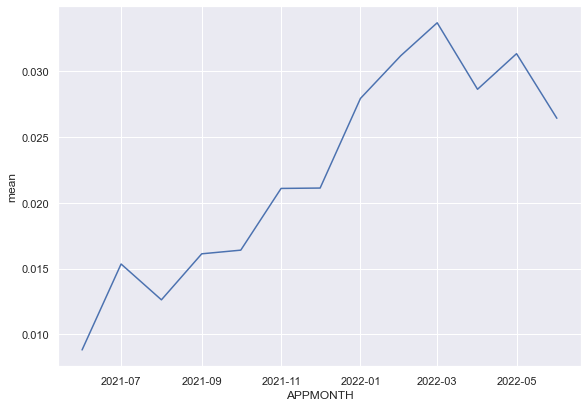

In [197]:
sns.lineplot(data=time_df, x="APPMONTH", y="mean")

<AxesSubplot:xlabel='APPMONTH', ylabel='count'>

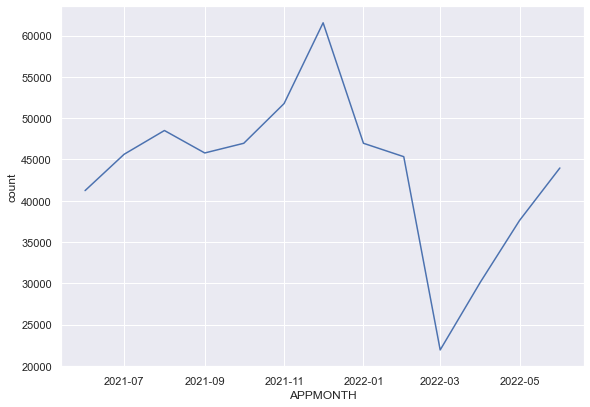

In [198]:
sns.lineplot(data=time_df, x="APPMONTH", y="count")

<div class="alert alert-block alert-info">
Видим, что кол-во и DR очень сильно меняются по месяцам.  

Есть тренд на рост DR и видим провал в кол-ве заявок в марте 2022. Причина падения понятна: из-за СВО
    
Также сумма кредитов очень сильно меняется во времени
</div> 

In [199]:
time_df = data_df[['APPMONTH', 'LIMIT']].groupby('APPMONTH').agg(['count', 'mean'])
time_df.columns  = ['count', 'mean']

<AxesSubplot:xlabel='APPMONTH', ylabel='mean'>

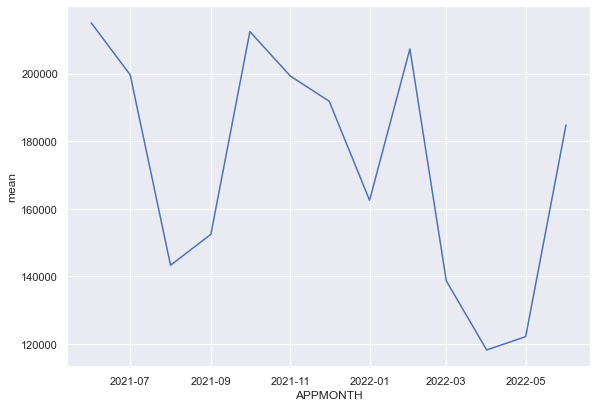

In [200]:
sns.lineplot(data=time_df, x="APPMONTH", y="mean")

# WOE и IV

In [202]:
data_df.head(2)

,PARTNER,APPID,DOCSERNUM,MOBILEPHONE,EMAIL,PRODUCTTYPE,CHANNEL,MODEL,TARGET,APPDT,APPMONTH,LIMIT
0,PARTNER28,APPLICATID1015331,DOCSERNUM1,MOBILEPHONE43681,EMAIL158187,Другой тип кредита,Значение не передается,0,0,2021-06-07,2021-06-01,0.000
1,PARTNER6,APPLICATID503939,DOCSERNUM2,MOBILEPHONE407081,EMAIL143461,Другой тип кредита,Точка продаж,EMPTY,0,2021-07-29,2021-07-01,0.000


In [203]:
nominal_inputs = ['PARTNER', 'PRODUCTTYPE', 'CHANNEL']
cont_inputs = ['LIMIT']
target = 'target'

In [265]:
def WoE_categorial(data, categorial_value):
    WoE = pd.crosstab(data[categorial_value].fillna('missing'), data['TARGET'])
    WoE.columns = ('Not-event', 'Event')
    WoE['% Not-event'] = WoE['Not-event']/WoE['Not-event'].sum()
    WoE['% Event'] = WoE['Event']/WoE['Event'].sum()
    WoE['WoE'] = np.log(WoE['% Not-event']/WoE['% Event'])
    WoE['IV'] = round((WoE['% Not-event'] - WoE['% Event']) * WoE['WoE'], 3)
    WoE['IV'] = round(WoE['IV'].replace([np.inf, -np.inf], 0), 3) # Заменяем inf на 0
    WoE['share_bin'] = (WoE['Not-event'] + WoE['Event']) / len(data)
    return WoE.sort_values('WoE')

In [266]:
WoE_channel = pd.crosstab(data_df["CHANNEL"], data_df["TARGET"])
WoE_channel.columns = ('Not-event', 'Event')
WoE_channel['% Not-event'] = WoE_channel['Not-event']/WoE_channel['Not-event'].sum()
WoE_channel['% Event'] = WoE_channel['Event']/WoE_channel['Event'].sum()
WoE_channel['WoE'] = np.log(WoE_channel['% Not-event']/WoE_channel['% Event'])
WoE_channel['IV'] = (WoE_channel['% Not-event'] - WoE_channel['% Event']) * WoE_channel['WoE']
WoE_channel['IV'] = WoE_channel['IV'].replace([np.inf, -np.inf], 0) # Заменяем inf на 0
WoE_channel

,Not-event,Event,% Not-event,% Event,WoE,IV
CHANNEL,,,,,,
Брокер (оффлайн),73787,687,0.133,0.056,0.862,0.066
Другое,408,5,0.001,0.000,0.588,0.000
Значение не передается,181159,3373,0.326,0.275,0.169,0.009
Интернет,47080,4260,0.085,0.348,-1.412,0.371
Колл-центр,1600,42,0.003,0.003,-0.174,0.000
Корпоративные продажи,243,1,0.000,0.000,1.679,0.001
Кросс-селл,10138,300,0.018,0.024,-0.294,0.002
Отделение,101247,701,0.182,0.057,1.159,0.145
Предварительная оценка заёмщика,332,13,0.001,0.001,-0.574,0.000


In [267]:
WoE_categorial(data_df, 'CHANNEL')

,Not-event,Event,% Not-event,% Event,WoE,IV,share_bin
CHANNEL,,,,,,,
Интернет,47080,4260,0.085,0.348,-1.412,0.371,0.090
Предварительная оценка заёмщика,332,13,0.001,0.001,-0.574,0.000,0.001
Кросс-селл,10138,300,0.018,0.024,-0.294,0.002,0.018
Колл-центр,1600,42,0.003,0.003,-0.174,0.000,0.003
Точка продаж,139152,2863,0.251,0.234,0.070,0.001,0.250
Значение не передается,181159,3373,0.326,0.275,0.169,0.009,0.325
Другое,408,5,0.001,0.000,0.588,0.000,0.001
Брокер (оффлайн),73787,687,0.133,0.056,0.862,0.066,0.131
Отделение,101247,701,0.182,0.057,1.159,0.145,0.180


In [268]:
WoE_categorial(data_df, 'CHANNEL')['IV'].sum()

0.595

In [351]:
# Создаем категориальную переменную
data_df['channel_cat'] = 0
category_num = 1
for i in WoE_categorial(data_df, 'CHANNEL').index:
    data_df['channel_cat'][(data_df['CHANNEL'] == i)] = category_num
    category_num +=1

C:\Users\75BD~1\AppData\Local\Temp/ipykernel_6048/1171448425.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['channel_cat'][(data_df['CHANNEL'] == i)] = category_num


In [352]:
WoE_categorial(data_df, 'PRODUCTTYPE')

,Not-event,Event,% Not-event,% Event,WoE,IV,share_bin
PRODUCTTYPE,,,,,,,
Микрозайм,16819,5314,0.030,0.434,-2.662,1.075,0.039
Дебетовая карта с овердрафтом,190,5,0.000,0.000,-0.177,0.000,0.000
Кредит наличными (нецелевой),33183,845,0.060,0.069,-0.144,0.001,0.060
Предварительная оценка заёмщика без указания типа кредита,1448,26,0.003,0.002,0.206,0.000,0.003
Кредитная карта,49783,879,0.090,0.072,0.223,0.004,0.089
Другой тип кредита,76695,1238,0.138,0.101,0.312,0.012,0.137
"POS кредит (потребительский кредит, кредит на товар)",263261,3372,0.474,0.275,0.544,0.108,0.470
Кредит на строительство недвижимости,189,2,0.000,0.000,0.734,0.000,0.000
Неизвестный тип кредита,86303,433,0.155,0.035,1.481,0.178,0.153


In [353]:
round(WoE_categorial(data_df, 'PRODUCTTYPE')['IV'].sum(), 3)

1.438

In [354]:
# Создаем категориальную переменную
data_df['product_type_cat'] = 0
category_num = 1
for i in WoE_categorial(data_df, 'PRODUCTTYPE').index:
    data_df['product_type_cat'][(data_df['PRODUCTTYPE'] == i)] = category_num
    category_num +=1

C:\Users\75BD~1\AppData\Local\Temp/ipykernel_6048/3636399519.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['product_type_cat'][(data_df['PRODUCTTYPE'] == i)] = category_num


In [355]:
WoE_categorial(data_df, 'product_type_cat')

,Not-event,Event,% Not-event,% Event,WoE,IV,share_bin
product_type_cat,,,,,,,
1,16819,5314,0.030,0.434,-2.662,1.075,0.039
2,190,5,0.000,0.000,-0.177,0.000,0.000
3,33183,845,0.060,0.069,-0.144,0.001,0.060
4,1448,26,0.003,0.002,0.206,0.000,0.003
5,49783,879,0.090,0.072,0.223,0.004,0.089
6,76695,1238,0.138,0.101,0.312,0.012,0.137
7,263261,3372,0.474,0.275,0.544,0.108,0.470
8,189,2,0.000,0.000,0.734,0.000,0.000
9,86303,433,0.155,0.035,1.481,0.178,0.153


In [356]:
WoE_categorial(data_df, 'PARTNER')

,Not-event,Event,% Not-event,% Event,WoE,IV,share_bin
PARTNER,,,,,,,
PARTNER42,2,9,0.000,0.001,-5.318,0.004,0.000
PARTNER21,96,89,0.000,0.007,-3.738,0.027,0.000
PARTNER29,122,99,0.000,0.008,-3.605,0.028,0.000
PARTNER2,1333,892,0.002,0.073,-3.412,0.240,0.004
PARTNER26,444,285,0.001,0.023,-3.371,0.076,0.001
PARTNER33,55,34,0.000,0.003,-3.333,0.009,0.000
PARTNER32,1111,611,0.002,0.050,-3.216,0.154,0.003
PARTNER25,974,524,0.002,0.043,-3.194,0.131,0.003
PARTNER41,192,101,0.000,0.008,-3.172,0.025,0.001


In [357]:
round(WoE_categorial(data_df, 'PARTNER')['IV'].sum(), 3)

1.642

In [359]:
# Создаем категориальную переменную партнер
data_df['partner_cat'] = 0
category_num = 1
for i in WoE_categorial(data_df, 'PARTNER').index:
    data_df['partner_cat'][(data_df['PARTNER'] == i)] = category_num
    category_num +=1

C:\Users\75BD~1\AppData\Local\Temp/ipykernel_6048/3156312907.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['partner_cat'][(data_df['PARTNER'] == i)] = category_num


In [443]:
# Создаем категориальную переменную наименование товара
data_df['model_cat'] = 2
data_df['model_cat'][(data_df['MODEL'] == 'EMPTY')] = 1
data_df['model_cat'][(data_df['MODEL'] == '0')] = 3
data_df['model_cat'][(data_df['MODEL'].isna())] = 0

C:\Users\75BD~1\AppData\Local\Temp/ipykernel_6048/873390443.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['model_cat'][(data_df['MODEL'] == 'EMPTY')] = 1
C:\Users\75BD~1\AppData\Local\Temp/ipykernel_6048/873390443.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['model_cat'][(data_df['MODEL'] == '0')] = 3
C:\Users\75BD~1\AppData\Local\Temp/ipykernel_6048/873390443.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

In [444]:
WoE_categorial(data_df, 'model_cat')

,Not-event,Event,% Not-event,% Event,WoE,IV,share_bin
model_cat,,,,,,,
0,137309,7421,0.247,0.606,-0.896,0.321,0.255
1,137993,1786,0.249,0.146,0.533,0.055,0.246
2,176695,1950,0.318,0.159,0.692,0.110,0.315
3,103149,1088,0.186,0.089,0.738,0.072,0.184


In [445]:
round(WoE_categorial(data_df, 'model_cat')['IV'].sum(), 3)

0.558

<div class="alert alert-block alert-info">
Видим, что все переменные хорошие 

Будет прогнозировать таргет от партнера, канала, типа продукта, наименование товара и суммы кредита  
В целом, можно уменьшить кол-во категорий в наших новых переменных, соединив категории с примерно одинаковым WoE
</div> 

# Глобальные переменные для модели

In [369]:
target = 'TARGET'

In [370]:
data_df.columns

Index(['PARTNER', 'APPID', 'DOCSERNUM', 'MOBILEPHONE', 'EMAIL', 'PRODUCTTYPE',
       'CHANNEL', 'MODEL', 'TARGET', 'APPDT', 'APPMONTH', 'LIMIT',
       'channel_cat', 'product_type_cat', 'partner_cat'],
      dtype='object')

In [450]:
X_list = ['LIMIT', 'channel_cat', 'product_type_cat', 'partner_cat', 'model_cat']

# Корреляция

In [451]:
data_df[X_list].corr()

,LIMIT,channel_cat,product_type_cat,partner_cat,model_cat
LIMIT,1.000,0.010,0.223,0.180,0.007
channel_cat,0.010,1.000,0.474,0.550,0.153
product_type_cat,0.223,0.474,1.000,0.646,0.213
partner_cat,0.180,0.550,0.646,1.000,0.323
model_cat,0.007,0.153,0.213,0.323,1.000


<div class="alert alert-block alert-info">
Корреляция между переменными есть, но не очень большая
</div> 

# Разбиваем на in-sample / out-sample

<div class="alert alert-block alert-danger">
Пропускаем этот этап, т.к. данные во времени распределены слишком неравномерно (см. "Распределение данных во времени")  
    
Также мы не будет исключать март 2022 года.
    
Но оба действия можно сделать :)
</div>

In [470]:
#data_in_sample = data[data['dt'] <= dt_sample]
#data_out_sample = data[data['dt'] > dt_sample]

data_in_sample = data_df

# Разбиваем на train/test

In [471]:
X = data_in_sample[X_list]
Y = data_in_sample[target]

In [472]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# Создаем модель

In [473]:
import statsmodels.api as sm
model=sm.Logit(Y_train , X_train)

In [474]:
result=model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.084600
         Iterations 10
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.190     
Dependent Variable: TARGET           AIC:              76812.0611
Date:               2023-07-30 23:51 BIC:              76867.1894
No. Observations:   453912           Log-Likelihood:   -38401.   
Df Model:           4                LL-Null:          -47423.   
Df Residuals:       453907           LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     10.0000                                      
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
LIMIT             0.0000   0.0000   0.6482 0.5168 -0.0000  0.0000
channel_cat      -0.0085   0.0054  -1.5556 0.1198 -0.0191  0.0022

In [492]:
logreg = LogisticRegression(solver='liblinear', C=10.0)
logreg.fit(X_train, Y_train)

LogisticRegression(C=10.0, solver='liblinear')

# Метрики качества модели

In [493]:
y_pred_proba_test = logreg.predict_proba(X_test) # прогноз на тесте
y_pred_proba_train = logreg.predict_proba(X_train) # прогноз на train
# y_pred_proba_out = logreg.predict_proba(X_out) # прогноз на out_sample

In [494]:
# Функция для получения предсказаний модели по заданному порогу
def pred_cutoff(tr, pred_proba):
    y_pred = np.zeros(shape = (len(pred_proba)))
    for i in range(len(pred_proba)):
        if pred_proba[i][1] >= tr:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    return y_pred

In [495]:
# np.linspace(0, 0.5, 21)

In [496]:
print(5 * ' ', 'Тестовая выборка')
for t in (0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5):
    y_pred_test = pred_cutoff(t, y_pred_proba_test)
    print('Threshold:', t , 'AUC:', round(roc_auc_score(Y_test, y_pred_test), 3))

      Тестовая выборка
Threshold: 0 AUC: 0.5
Threshold: 0.01 AUC: 0.697
Threshold: 0.02 AUC: 0.716
Threshold: 0.03 AUC: 0.73
Threshold: 0.04 AUC: 0.731
Threshold: 0.05 AUC: 0.731
Threshold: 0.1 AUC: 0.707
Threshold: 0.15 AUC: 0.657
Threshold: 0.2 AUC: 0.606
Threshold: 0.25 AUC: 0.555
Threshold: 0.3 AUC: 0.554
Threshold: 0.35 AUC: 0.543
Threshold: 0.4 AUC: 0.504
Threshold: 0.45 AUC: 0.5
Threshold: 0.5 AUC: 0.5


In [497]:
# precision/recall. Threshold - 0.05

Th = 0.05

In [498]:
y_pred_train = pred_cutoff(Th, y_pred_proba_train)
y_pred_test = pred_cutoff(Th, y_pred_proba_test)
# y_pred_out = pred_cutoff(Th, y_pred_proba_out)

In [499]:
print(20 * ' ', 'Обучающая выборка')
print(classification_report(Y_train, y_pred_train))

                     Обучающая выборка
              precision    recall  f1-score   support

           0       0.99      0.91      0.95    444075
           1       0.11      0.54      0.19      9837

    accuracy                           0.90    453912
   macro avg       0.55      0.72      0.57    453912
weighted avg       0.97      0.90      0.93    453912



In [500]:
print(20 * ' ', 'Тестовая выборка')
print(classification_report(Y_test, y_pred_test))

                     Тестовая выборка
              precision    recall  f1-score   support

           0       0.99      0.90      0.94    111071
           1       0.11      0.56      0.19      2408

    accuracy                           0.90    113479
   macro avg       0.55      0.73      0.57    113479
weighted avg       0.97      0.90      0.93    113479



In [501]:
# Вывод: Модель стабильна и не деградирует на test

In [502]:
model_roc_auc = roc_auc_score(Y_test, y_pred_test)
model_roc_auc

0.7307887055034176

In [506]:
#confusion_matrix = confusion_matrix(Y_test, y_pred_test)
#print(confusion_matrix)

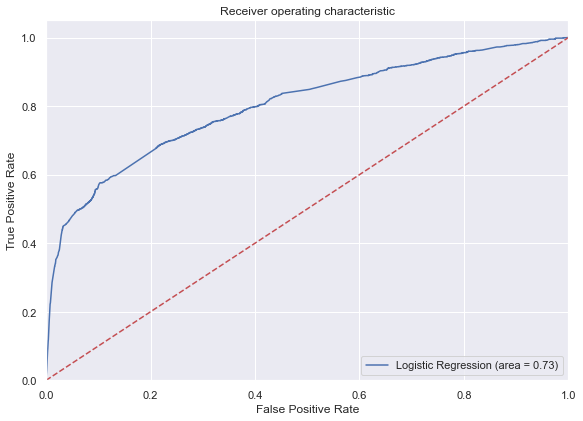

In [484]:
logit_roc_auc = roc_auc_score(Y_test, y_pred_test)
fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Предсказываю вероятности дефолта для всего файла

In [485]:
predict_proba_all = logreg.predict_proba(data_df[X_list])

In [486]:
predict_all = pred_cutoff(Th, predict_proba_all)

In [487]:
data_df['predict_proba'] = predict_proba_all[:, 1]
data_df['predict'] = predict_all

In [488]:
data_df.head()

,PARTNER,APPID,DOCSERNUM,MOBILEPHONE,EMAIL,PRODUCTTYPE,CHANNEL,MODEL,TARGET,APPDT,APPMONTH,LIMIT,channel_cat,product_type_cat,partner_cat,predict_proba,predict,model_cat
0,PARTNER28,APPLICATID1015331,DOCSERNUM1,MOBILEPHONE43681,EMAIL158187,Другой тип кредита,Значение не передается,0,0,2021-06-07,2021-06-01,0.000,6,6,33,0.008,0.000,3
1,PARTNER6,APPLICATID503939,DOCSERNUM2,MOBILEPHONE407081,EMAIL143461,Другой тип кредита,Точка продаж,EMPTY,0,2021-07-29,2021-07-01,0.000,5,6,25,0.023,0.000,1
2,PARTNER6,APPLICATID503936,DOCSERNUM2,MOBILEPHONE407081,EMAIL143461,"POS кредит (потребительский кредит, кредит на товар)",Точка продаж,"15.6"" Ноутбук HP Laptop 15-gw0040ur (FHD/IPS) Athlon 3150u/4096/SSD 256/AMD R620 2Gb/Win10/Gray HP",0,2021-07-29,2021-07-01,32374.100,5,7,25,0.023,0.000,2
3,PARTNER6,APPLICATID503947,DOCSERNUM2,MOBILEPHONE407081,EMAIL143461,"POS кредит (потребительский кредит, кредит на товар)",Точка продаж,"15.6"" Ноутбук HP Laptop 15s-eq1261ur (FHD/IPS) Ryzen 3 3250U/8192/SSD 256/AMD Radeon Vega/Dos/Gray HP",0,2021-07-29,2021-07-01,30524.100,5,7,25,0.023,0.000,2
4,PARTNER6,APPLICATID503948,DOCSERNUM2,MOBILEPHONE407081,EMAIL143461,Другой тип кредита,Точка продаж,EMPTY,0,2021-07-29,2021-07-01,0.000,5,6,25,0.023,0.000,1


In [489]:
# сохраняю результат
data_df.to_excel('result_BKI.xlsx', index = False)

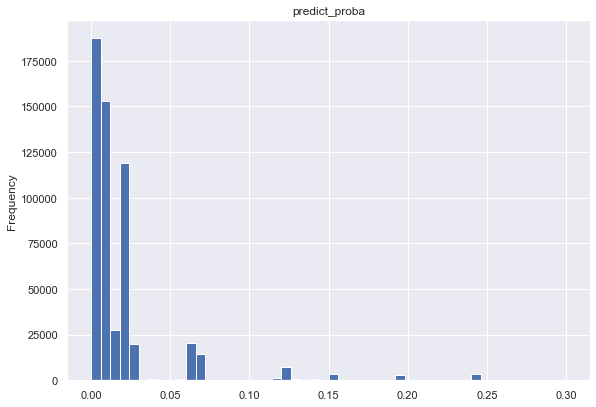

In [507]:
plt.hist(data_df['predict_proba'], bins = 50, range = (0, 0.3))
plt.title('predict_proba')
plt.ylabel('Frequency')
plt.show()

# Выводы

<div class="alert alert-block alert-success">
Модель получилось неплохого качества - ROC AUC = 0.73, Это соответсвует GINI 46%  
    
В целом, можно максимизировать вместо ROC AUC метрики precision/recall.   
    
    
Recall у нас получился 0.56, т.е. более половину событий предсказываем верно  
Но при этом можно поработать с точность модели для класс 1, т.к. 0.11 довольно мало. Хотя и сильно выше, чем наивный прогноз равным среднему значению таргета (0.022)
    
</div>

# Другое

In [437]:
import webbrowser
webbrowser.open('https://www.youtube.com/watch?v=5F_Kj5xgAcg')

True